In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [167]:
DICT_LINK_INDEX = {'Admin':1,'Banking':1,'Education':1,'Manufacture':1}
DICT_COMPANY_INDEX = {'Admin':2,'Banking':2,'Education':2,'Manufacture':2}
DICT_AREA_INDEX = {'Admin':3,'Banking':3,'Education':3,'Manufacture':3}
DICT_DATE_INDEX = {'Admin':4,'Banking':5,'Education':5,'Manufacture':5}
DICT_CLASSFICATION_INDEX = {'Admin':5,'Banking':6,'Education':6,'Manufacture':6}
DICT_SALARY_FLOOR = {'Admin':35000,'Banking':53000,'Education':48000,'Manufacture':24600}
DICT_SALARY_CEILING = {'Admin':55000,'Banking':85000,'Education':79000,'Manufacture':116000}
ANNUAL_WORKING_HOUR = 8*200

In [168]:
def pre_cleaning(df,i,j,k):
    df['company_name']=df[i]
    df[['posted_time','featured_at']]=df[j].str.split(',',expand=True)[[0,2]]
    df.loc[df['company_name'].isna(),'company_name']= df['featured_at']
    df['ad_type']= df[k].str.extract('\=(\w+)\#')
    return df

In [169]:
def listing_time_cleaning(df):
    df['listing_time_indays'] = df['posted_time'].str.extract('(\d+[a-z])')
    df['listing_time_indays'] = df['listing_time_indays'].str.extract('(\w+)d')
    df['listing_time_indays'].fillna('0', inplace = True)
    df['listing_time_indays'] #notice that if the ad_type is promoted, the listing time is recorded as "Featured", which means the listing times of those featured advs may be longer.
    return df

In [170]:
#useful function
def deduplication(x):
    mid = len(x)//2
    if x != 'unknown':
        return x[:mid+1]
    else:
        return 'unknown'
def smart_deduplication(x):
    trim = x.strip()
    index = (trim+trim).find(trim,1)
    if index != -1:
        return trim[:index]
    else:
        return 'unknown'

In [171]:
def location_cleaning(df,i):
    df[['location','area']] = df[i].str.split("area:",expand= True)
    df['location'] = df['location'].apply(lambda x:x[9:])
    df['location'] = df['location'].apply(smart_deduplication)
    df['area'].fillna('unknown', inplace = True)
    df['area'] = df['area'].apply(smart_deduplication)
    return df

In [172]:
def classification_cleaning(df,i):
    df[['subclassification','Classification']] = df[i].str.split('subClassification:',expand=True)
    df['subclassification'] = df['subclassification'].apply(lambda x:x[15:])
    df['Classification'].fillna('unknown', inplace = True)
    df['Classification'] = df['Classification'].apply(smart_deduplication)
    df[['mainClassification','7','subclassification']] = df['subclassification'].str.split('&',expand=True)
    df['subclassification'].fillna('unknown', inplace = True)
    return df

In [173]:
def random_salary(df,i,salary_floor,salary_ceiling):    
    df['salary']=df[i]
    df[df['salary'].str.contains('\d',na=False)]['salary']
    df['salary']= df[df['salary'].str.contains('\d',na=False)]['salary'].str.replace(' to ','-',regex=True)
    df['salary']= df[df['salary'].str.contains('\d',na=False)]['salary'].str.replace('\d\%','',regex=True)
    df['salary']= df[df['salary'].str.contains('\d',na=False)]['salary'].str.replace(',','',regex=True)
    df['salary']= df[df['salary'].str.contains('\d',na=False)]['salary'].str.replace(' ','',regex=True)
    df['salary'].fillna('unknown', inplace=True)
    df[['low_salary','high_salary']] = df['salary'].str.split('-', n=1,expand=True).fillna('unknown')
    df['low_salary'] = df['low_salary'].str.extract('(\d+\.\d+|\d+ \d+|\d+k|\d+)')
    df['high_salary'] = df['high_salary'].str.extract('(\d+\.\d+|\d+ \d+|\d+k|\d+)')
    df['low_salary'] = df[df['low_salary'].str.contains('\d',na=False)]['low_salary'].str.replace('k', '000',regex=True)
    df['high_salary'] = df[df['high_salary'].str.contains('\d',na=False)]['high_salary'].str.replace('k', '000',regex=True)
    df['low_salary'] = df['low_salary'].fillna('unknown')
    df['high_salary'] = df['high_salary'].fillna('unknown')
    df.loc[df['low_salary'] == 'unknown', 'low_salary'] = df['high_salary']
    df.loc[df['high_salary'] == 'unknown', 'high_salary'] = df['low_salary']

    for r, row in enumerate(df['low_salary'].values):
        if row == 'unknown':
            df['low_salary'][r] = np.random.randint(salary_floor, salary_ceiling, size=1)[0]

    for r, row in enumerate(df['high_salary'].values):
        if row == 'unknown':
            df['high_salary'][r] = max(np.random.randint(salary_floor, salary_ceiling, size=1)[0], df['low_salary'][r])
    df['low_salary'] = df['low_salary'].astype('float32')
    df['high_salary'] = df['high_salary'].astype('float32')
    df.loc[df['low_salary'] < 50, 'low_salary'] =df['low_salary'] * ANNUAL_WORKING_HOUR
    df.loc[df['high_salary'] < 50, 'high_salary'] =df['high_salary'] * ANNUAL_WORKING_HOUR
    
    #threshold = (45000+75000) /2
    #df['lower_salary'] = np.random.randint(45000, threshold, df.shape[0])
    #df['upper_salary'] = np.random.randint(threshold, 75000, df.shape[0])

    return df



In [174]:
def clean_jobs(file_name,job):
    df = pd.read_excel(file_name,engine="openpyxl",header = None)
    clean_job = (df.pipe(pre_cleaning,DICT_COMPANY_INDEX[job],DICT_DATE_INDEX[job],DICT_LINK_INDEX[job]).
        pipe(listing_time_cleaning).
        pipe(location_cleaning,DICT_AREA_INDEX[job]).
        pipe(classification_cleaning,DICT_CLASSFICATION_INDEX[job]).
        pipe(random_salary,DICT_CLASSFICATION_INDEX[job],DICT_SALARY_FLOOR[job],DICT_SALARY_CEILING[job])#salary floor and ceiling
    )
    return df

In [175]:

df = clean_jobs("NZ_Admin_JOBS.xlsx",'Admin') #input the file name
df[['company_name', 'posted_time','ad_type','listing_time_indays','location','area','Classification','low_salary','high_salary']]


,company_name,posted_time,ad_type,listing_time_indays,location,area,Classification,low_salary,high_salary
0,Private Advertiser,Featured,promoted,0,Bay of Plenty,Tauranga,Office Management,48728.0,48728.0
1,Avenues Orthodontics,Featured,promoted,0,Bay of Plenty,Tauranga,Receptionists,45856.0,51100.0
2,New Zealand Police,4d ago,standard,4,Auckland,unknown,Other,52446.0,52446.0
3,Kew Pacific Island Early Learning Centre,1h ago,standard,0,Southland,Invercargill,Administrative Assistants,52230.0,52480.0
4,Private Advertiser,4d ago,standout,4,Canterbury,Christchurch,Client & Sales Administration,39828.0,51588.0
...,...,...,...,...,...,...,...,...,...
2703,Hays Talent Solutions,27d ago,standout,27,Auckland,Auckland Central,Client & Sales Administration,39438.0,52045.0
2704,one eighty recruitment,27d ago,standout,27,Wellington,"Wellington CentralWellington Central,Competiti...",unknown,54742.0,54742.0
2705,Asset Recruitment Ltd,20d ago,standout,20,Waikato,"HamiltonHamilton,Competitive hourly rates $$",unknown,42631.0,50192.0
2706,Asset Recruitment Ltd,28d ago,standout,28,Waikato,"HamiltonHamilton,Competitive hourly rates $$",unknown,49080.0,53968.0


In [176]:
df.loc[df['location'].str.contains('Acukland'),'location'] = 'Auckland'
df.loc[df['location'].str.contains('Wellington'),'location'] = 'Wellington'

# Report

## low_salary and high_salary comparison

Text(0.5, 1.0, 'max_salary distribution')

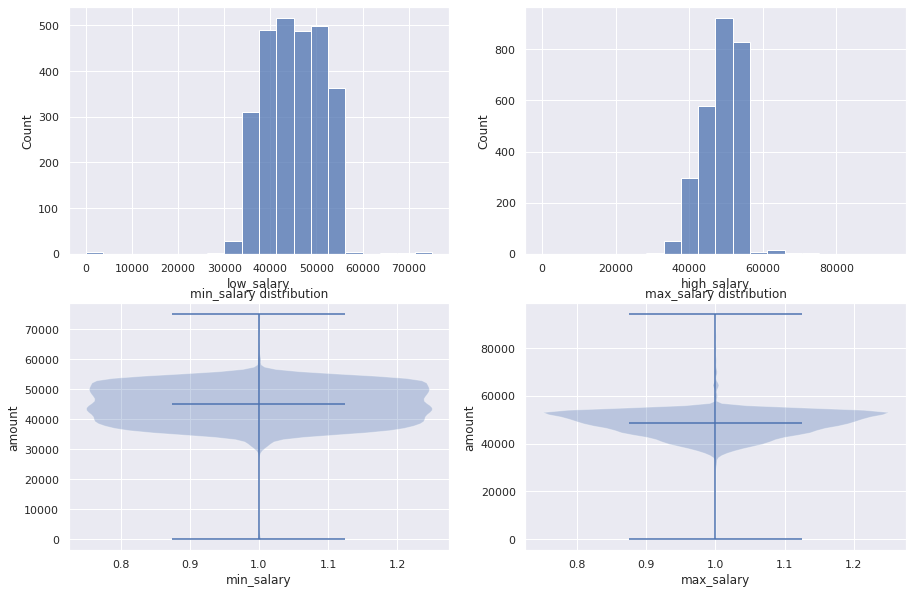

In [177]:
sns.set_theme(style='darkgrid')
fig,axs = plt.subplots(nrows=2,ncols=2,figsize=(15,10))
sns.histplot(df['low_salary'],palette="light:m_r",bins=20, ax= axs[0][0])
sns.histplot(df['high_salary'],palette="light:m_r",bins=20, ax= axs[0][1])
axs[1][0].violinplot(df['low_salary'],showmeans = True)
axs[1][0].set_xlabel('min_salary')
axs[1][0].set_ylabel('amount')
axs[1][0].set_title('min_salary distribution')
axs[1][1].violinplot(df['high_salary'],showmeans = True)
axs[1][1].set_xlabel('max_salary')
axs[1][1].set_ylabel('amount')
axs[1][1].set_title('max_salary distribution')

There are slight differences between high and low salary.

# Relation ship between listing time and salary

<AxesSubplot:xlabel='listing_time_indays'>

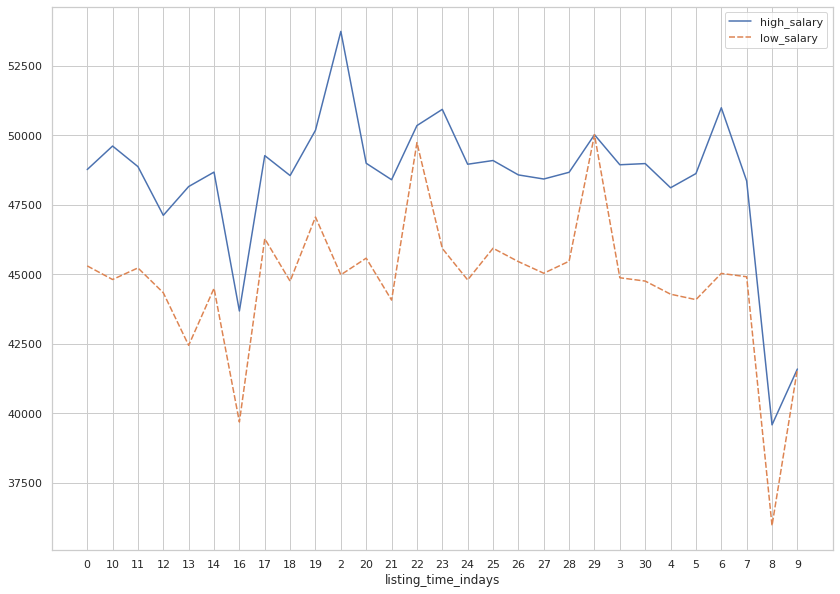

In [199]:
line = df[['listing_time_indays','high_salary','low_salary']].groupby(['listing_time_indays']).mean()
plt.figure(figsize=(14,10))
sns.lineplot(data=line)

There are negative relationships between listing time and salarys # the plots is not accurate as the salary is randomly generated.


## Salary distribution for listing time

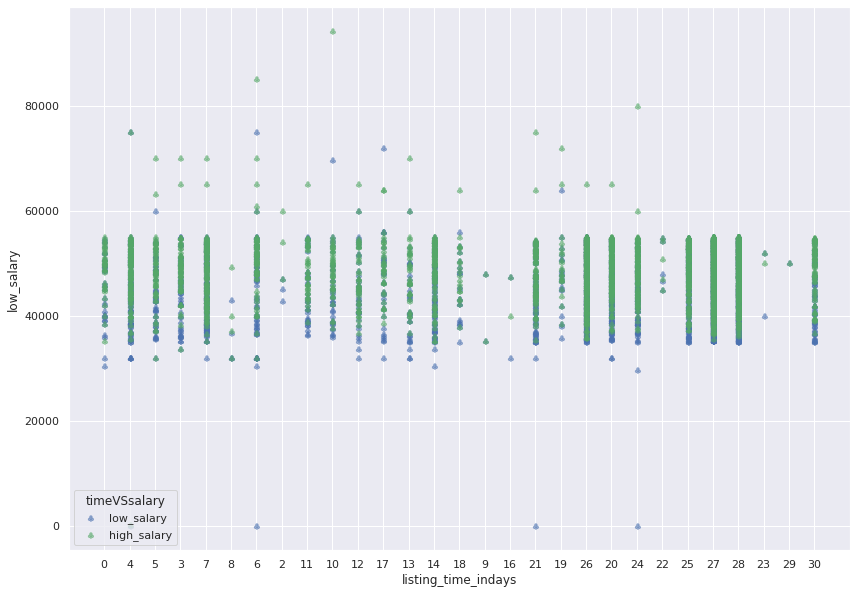

In [179]:

# Fixing random state for reproducibility
np.random.seed(20210326)


plt.figure(figsize=(14,10))#set the size
x = df['listing_time_indays']
y = df['low_salary']
y1 = df['high_salary']
plt.scatter(x, y, c="b", alpha=0.5, marker=r'$\clubsuit$',
            label="timeVSsalary")
plt.scatter(x, y1, c="g", alpha=0.5, marker=r'$\clubsuit$')
plt.xlabel("listing_time_indays")
plt.ylabel("low_salary")
plt.legend(['low_salary','high_salary'],
                    loc="lower left", title="timeVSsalary")
plt.show()

<ipython-input-180-e6cb69b00f7f>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sns.heatmap(df.groupby('listing_time_indays')['low_salary','high_salary'].mean(),center=45000)


<AxesSubplot:ylabel='listing_time_indays'>

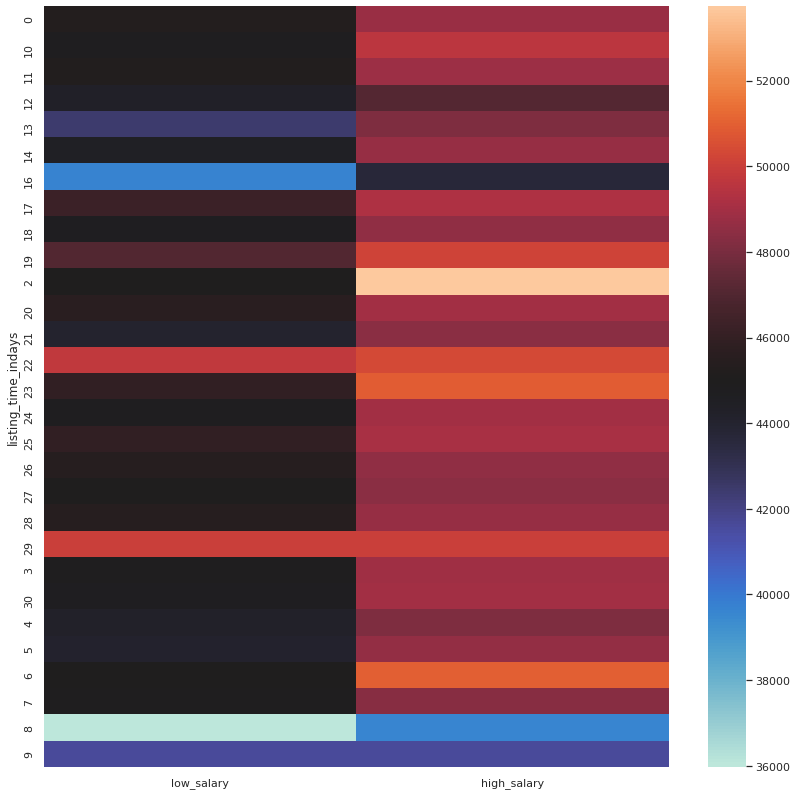

In [180]:
plt.figure(figsize=(14,14))
sns.heatmap(df.groupby('listing_time_indays')['low_salary','high_salary'].mean(),center=45000)

As we can see from scatter plot，there are some outliers from low salary which is 0, most list_times of high-paying jobs do not exceed half of month. There are slight differences between high and low salary. The heat map shows us that there is no evidence that the listing time is not directly related to salary, only some outstanding salarys does.

## Salary distribution for location

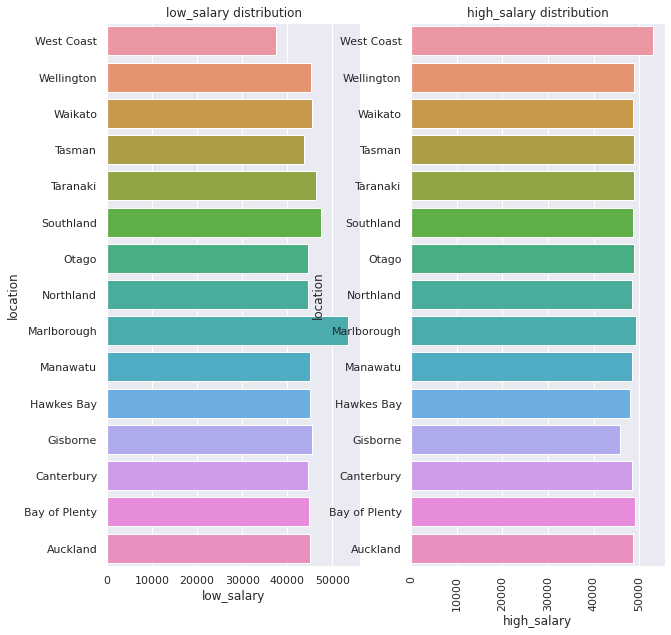

In [181]:
area_salary = df[['location','low_salary','high_salary']].groupby(['location']).mean().reset_index().drop([1,2])

area_salary = area_salary.sort_values(by=['location'],ascending=False)

fig, axs = plt.subplots(nrows = 1, ncols =2, figsize=(10, 10))
sns.barplot(y="location", x="low_salary", data=area_salary, ax=axs[0])
axs[0].set_title('low_salary distribution')
sns.barplot(y="location", x="high_salary", data=area_salary, ax=axs[1])
axs[1].set_title('high_salary distribution')
axs[1].tick_params(axis='x',rotation=90)

In barplot above, we found that the West Coast city has the highest average salary.The gap of the high and low salary in West Coast is largest compair to other cities.  The gap of the high and low salary in Marlborough is smallest，
the salary in this city ismore average. For Auckland and Wellington, which have the most job opportunities, their average salary is not that outstanding.

## Top 10 number of job in locations

(array([   0.,  200.,  400.,  600.,  800., 1000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

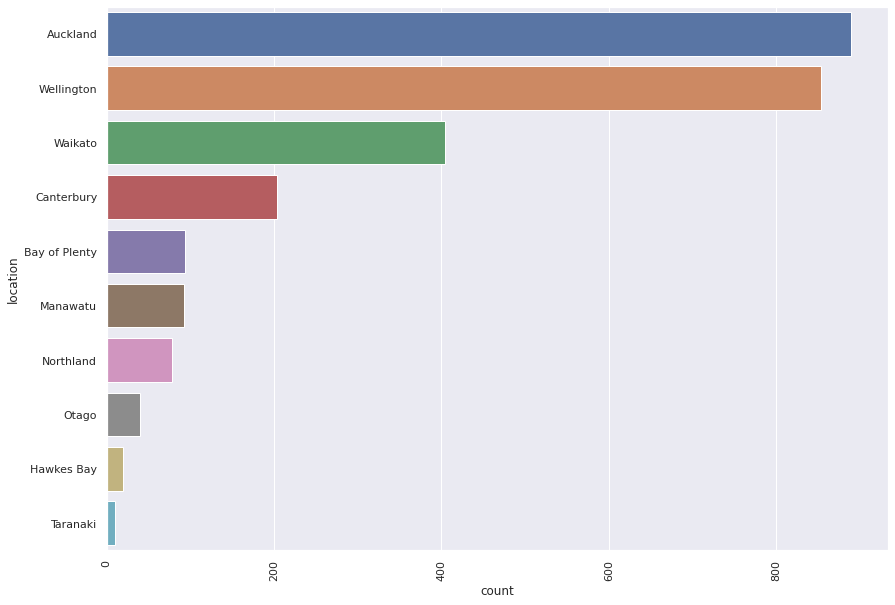

In [182]:
df['count'] = 1
jobplot = df[['location','count']].groupby(['location']).sum().reset_index()
jobplot = jobplot.sort_values(by=['count'],ascending=False).head(10)
plt.figure(figsize=(14,10))
ax =sns.barplot(y="location", x="count", data=jobplot)
plt.xticks(rotation = 90)

<AxesSubplot:ylabel='count'>

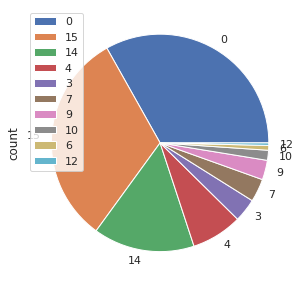

In [222]:
jobplot[['location','count']].plot.pie(x='location',y='count', figsize=(5, 5))

Auckland and Wellington have more job opportunities than other cities, and the differences are very large. Except for the top five major cities, other cities have no demand for this job.

## Is premotion useful in NZ SEEK? What is the relation ship between listing time and job classification?

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Office Management'),
  Text(1, 0, 'Receptionists'),
  Text(2, 0, 'Other'),
  Text(3, 0, 'Administrative Assistants'),
  Text(4, 0, 'Client & Sales Administration'),
  Text(5, 0, 'Data Entry & Word Processing'),
  Text(6, 0, 'PA, EA & Secretarial'),
  Text(7, 0, 'Contracts Administration'),
  Text(8, 0, 'Records Management & Document Control')])

<Figure size 1008x720 with 0 Axes>

<Figure size 1008x720 with 0 Axes>

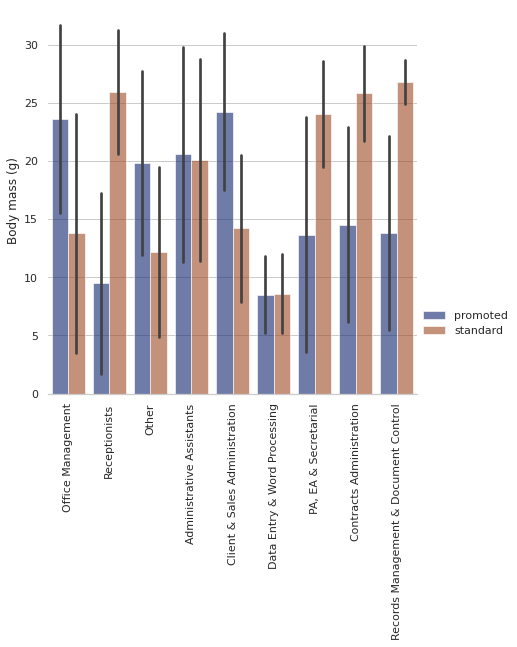

In [191]:

df.loc[df['ad_type'].str.contains('standout'),'ad_type'] = 'promoted'
df.loc[df['Classification'].str.contains('unknow'),'Classification'] = 'Other'

sns.set_theme(style="whitegrid")

# Draw a nested barplot by species and sex
plt.figure(figsize=(14,10))
y1=df["listing_time_indays"].astype(int)
g = sns.catplot(
    data=df, kind="bar",
    x="Classification", y=y1, hue="ad_type",
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Body mass (g)")
g.legend.set_title("")
plt.xticks(rotation = 90)

<AxesSubplot:xlabel='ad_type', ylabel='listing_time_indays'>

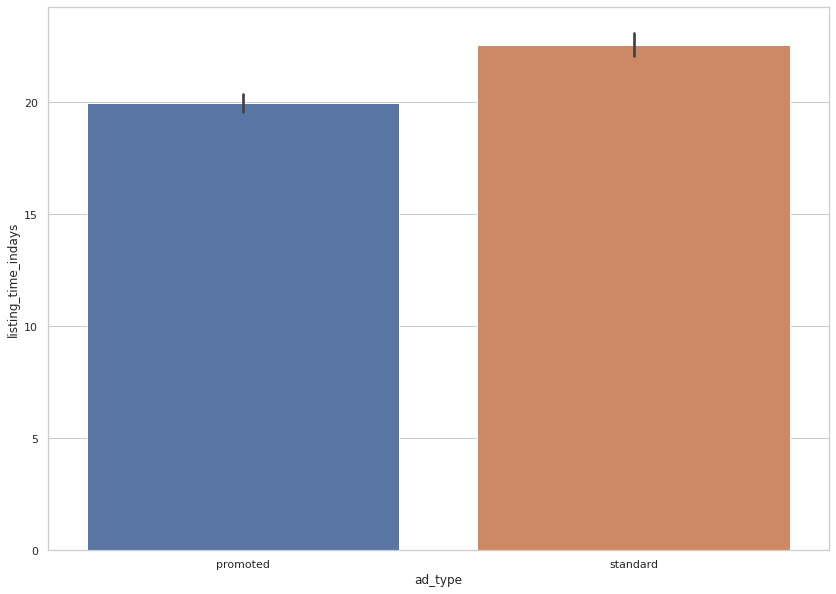

In [193]:
plt.figure(figsize=(14,10))
sns.barplot(y=y1, x="ad_type", data=df)


In [ ]:
The most popular job is Data Entry. And promoted recruitment advertisements in NZ SEEK are not obvirously effective.

In [ ]:
Now we disscuss why Data Entry is the most popular job.

## Salary in different jobs

(array([    0., 10000., 20000., 30000., 40000., 50000., 60000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

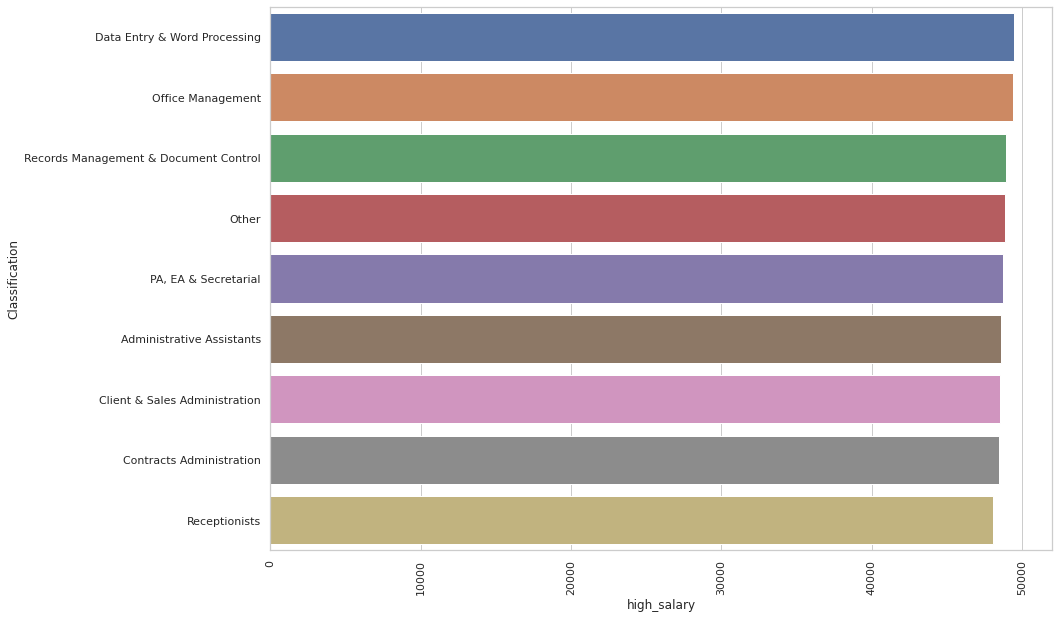

In [194]:
job_salary=df[['high_salary',"Classification"]].groupby(["Classification"]).mean().reset_index().sort_values(by=['high_salary'],ascending=False)
plt.figure(figsize=(14,10))
sns.barplot(x='high_salary', y="Classification", data=job_salary)
plt.xticks(rotation = 90)

The reason why data entry is most popular job is the salary of data entry is highest.